### Tech Challenge Fase 1

O objetivo é o desenvolvimento de um **modelo preditivo de regressão** para estimar os **custos de planos de saúde individuais**.

Os dados utilizados para a análise possuem as seguintes informações:

- Idade (age)
- Gênero (sex)
- IMC (bmi)
- Número de filhos (children)
- Se a pessoa é fumante (smoker)
- Região onde reside (region)
- Custo do plano de saúde (charges)

O processo de desenvolvimento do modelo passará pelas fases de:

1) **Preparação do ambiente**

2) **Exploração de Dados**

3) **Pré-processamento de Dados**

4) **Treinamento e Avaliação dos Modelos**

#### 1) Preparação do ambiente

Nessa fase iremos fazer a **importação das bibliotecas** e **leitura dos dados** que serão utilizados para a análise.

In [40]:
!pip install plotly_express

In [104]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [86]:
df = pd.read_csv("02_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2) Exploração dos Dados

Para entender a estrutura, os padrões do dataset e possíveis problemas no dataset, serão feitas algumas análises que envolve:

2.1) Estatísticas descritivas

2.2) Distribuição das variáveis

2.3) Análise de correlação

2.4) Análise bivariada

#### 2.1) Estatísticas descritivas

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [74]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Com base no resumo apresentado acima, podemos identificar as seguintes informações:

**Valores de Cobrança:**

- O valor máximo cobrado de um paciente é de 63.770,43;
- O valor mínimo cobrado de um paciente é de 1.121,87.

**Idade:**

- A idade dos pacientes está compreendida entre 18 e 64 anos com uma média de aprox. 39 anos.

**Número de Filhos:**

- O número de filhos por paciente varia de 0 a 5.

**Índice de Massa Corporal (IMC):**

- O IMC máximo registrado é de 53;
- O IMC mínimo registrado é de 15.

#### 2.2) Distribuição das variáveis

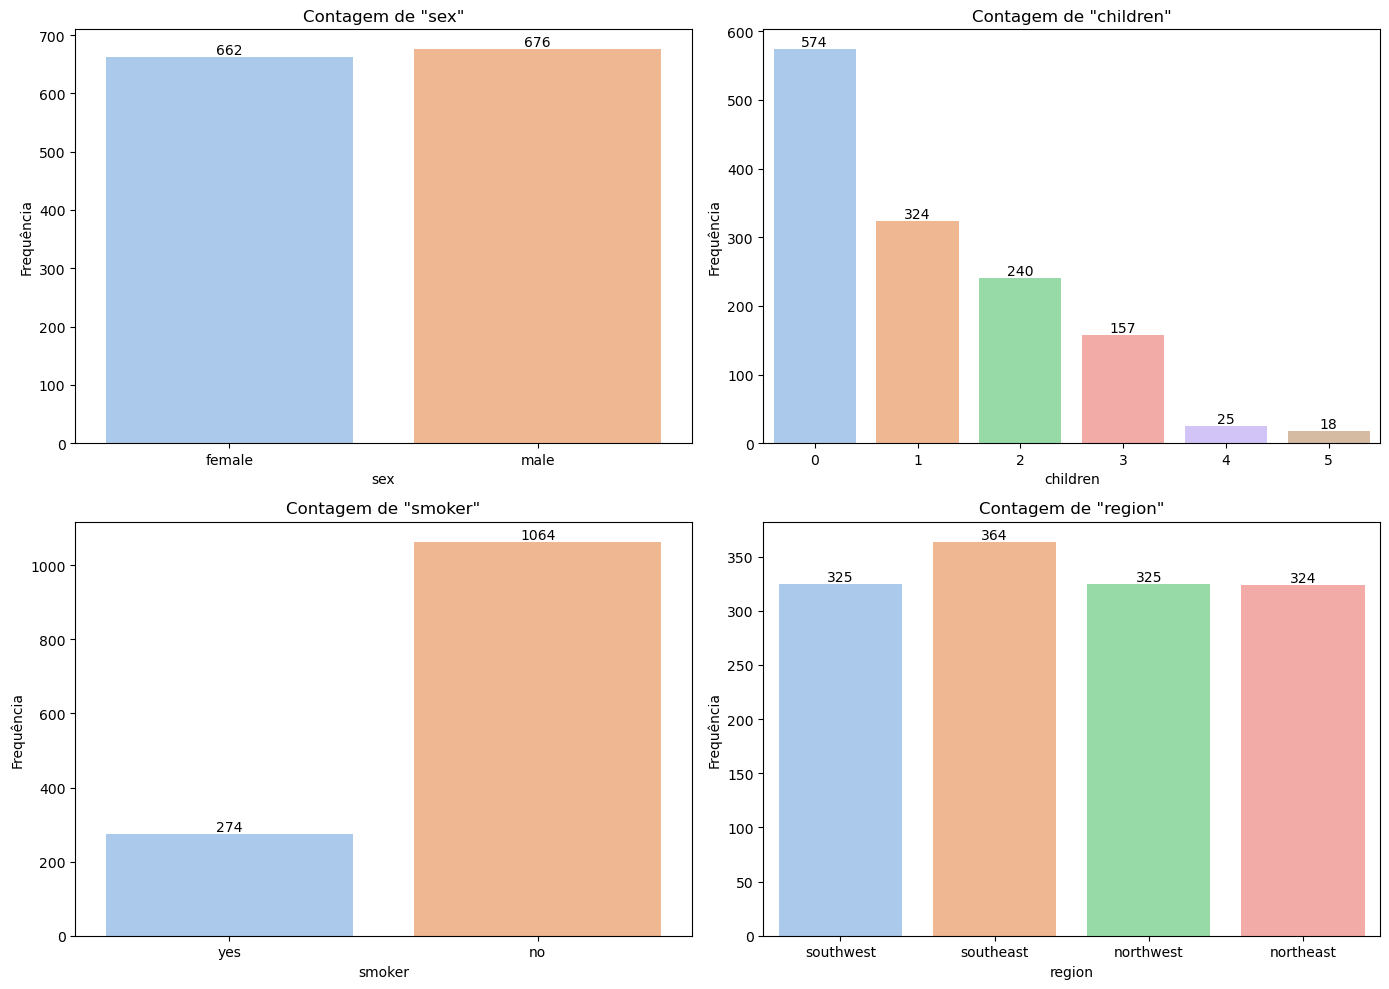

In [75]:
# Colunas categóricas
cat_cols = ['sex', 'children', 'smoker', 'region']

# Configurando os subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Achata a matriz de eixos para facilitar a iteração

# Configurando a paleta de cores
palette = sns.color_palette('pastel')

# Gerando os gráficos de barras com rótulos
for i, col in enumerate(cat_cols):
    ax = sns.countplot(data=df, x=col, ax=axes[i], palette=palette)
    ax.set_title(f'Contagem de "{col}"')
    ax.set_ylabel('Frequência')
    ax.set_xlabel(col)
    
    # Adicionando rótulos de contagem em cada barra
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()  # Ajusta os subplots para não sobrepor
plt.show()

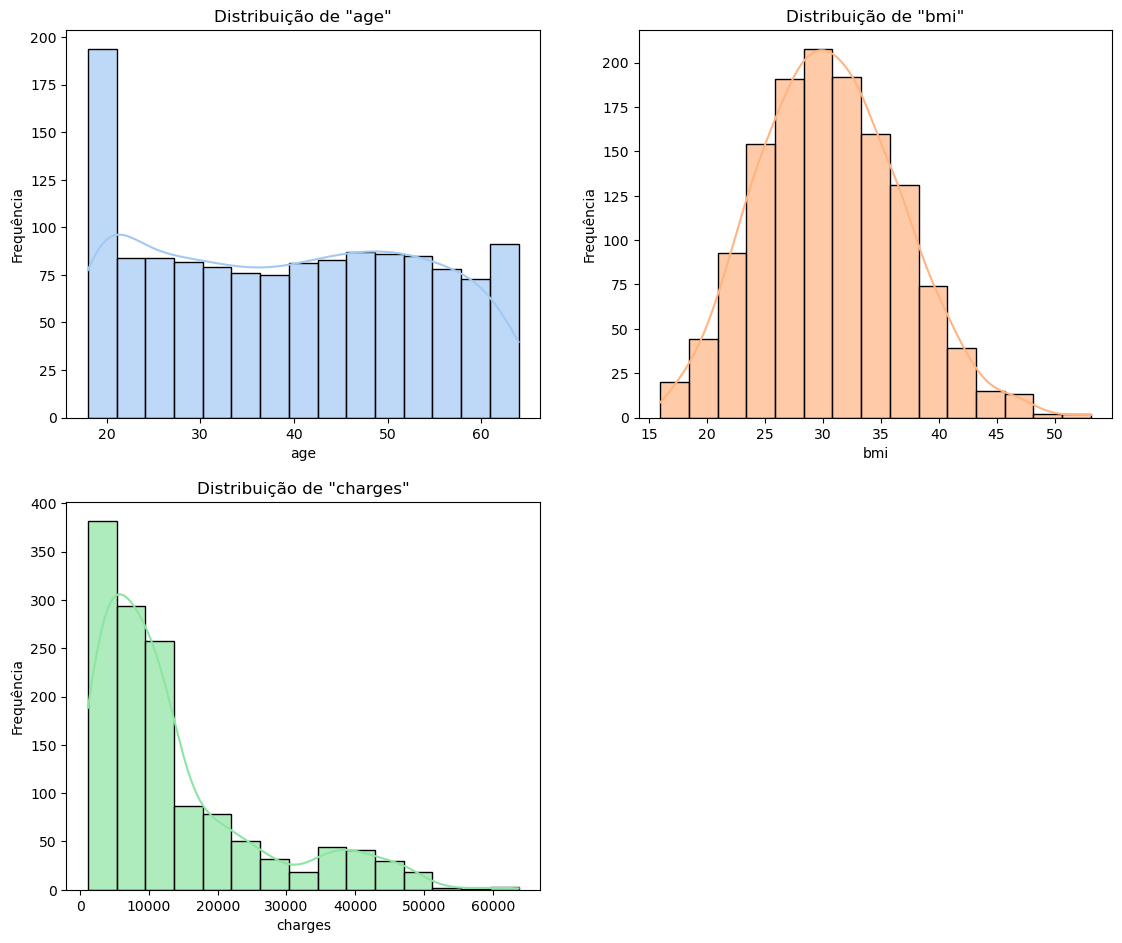

In [156]:
# Lista de variáveis numéricas
num_cols = ['age', 'bmi', 'charges']

# Configuração do grid para as subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # grade 2x2
fig.tight_layout(pad=4.0)

# Configurando a paleta de cores
palette = sns.color_palette('pastel')

# Gera os histogramas para cada variável
for i, col in enumerate(num_cols):
    ax = sns.histplot(data=df, x=col, ax=axes[i // 2, i % 2], kde=True, color=palette[i % len(palette)], bins=15, alpha=0.7)
    ax.set_title(f'Distribuição de "{col}"')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')

# Remover o eixo não utilizado
fig.delaxes(axes[-1][1])

plt.show()

In [77]:
# Avaliando a presença de valores nulos
(
    df.isnull()
    .sum()
    .to_frame()
    .reset_index()
    .rename({"index": "column", 0: "valores_nulos"}, axis=1)
)

,column,valores_nulos
0,age,0
1,sex,0
2,bmi,0
3,children,0
4,smoker,0
5,region,0
6,charges,0


In [88]:
# Criando coluna boolena para identificar se tem filho ou não
df.loc[df["children"] > 0, "has_children"] = "yes"
df["has_children"].fillna("no", inplace=True)

In [89]:
df.head()

,age,sex,bmi,children,smoker,region,charges,has_children
0,19,female,27.900,0,yes,southwest,16884.92400,no
1,18,male,33.770,1,no,southeast,1725.55230,yes
2,28,male,33.000,3,no,southeast,4449.46200,yes
3,33,male,22.705,0,no,northwest,21984.47061,no
4,32,male,28.880,0,no,northwest,3866.85520,no


#### 2.3 Análise de correlação

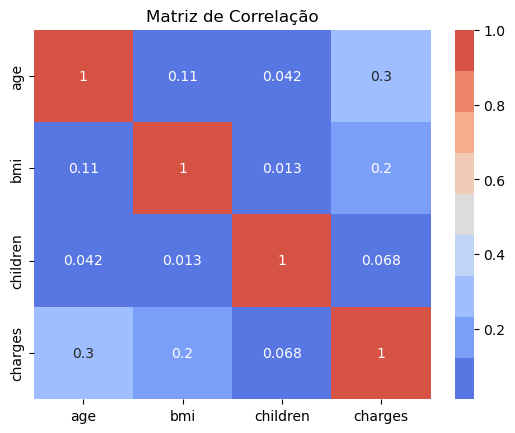

In [175]:
# Seleciona apenas as colunas numéricas para o cálculo da correlação
numerical_df = df.select_dtypes(include=['number'])
div_palette = sns.color_palette("coolwarm", 9)
# Criação da matriz de correlação entre as variáveis numéricas
sns.heatmap(numerical_df.corr(), annot=True, cmap=div_palette)
plt.title('Matriz de Correlação')
plt.show()

De acordo com o resultado obtido com a matriz de correlação das variáveis numéricas, podemos concluir que:


- A correlação entre **custos e IMC é positiva, mas relativamente baixa**, com um coeficiente em torno de 0.2.
- A correlação entre **custos e idade é positiva e moderada**, com um coeficiente em torno de 0.3.
- A correlação entre **custos e número de filhos é muito baixa**, com um coeficiente de apenas 0.068.

**Conclusão:**

A matriz de correlação sugere que **idade e IMC são mais relevantes para prever custos**, enquanto **número de filhos** pode ter uma **menor prioridade na modelagem** preditiva.


#### 2.4 Análise bivariada

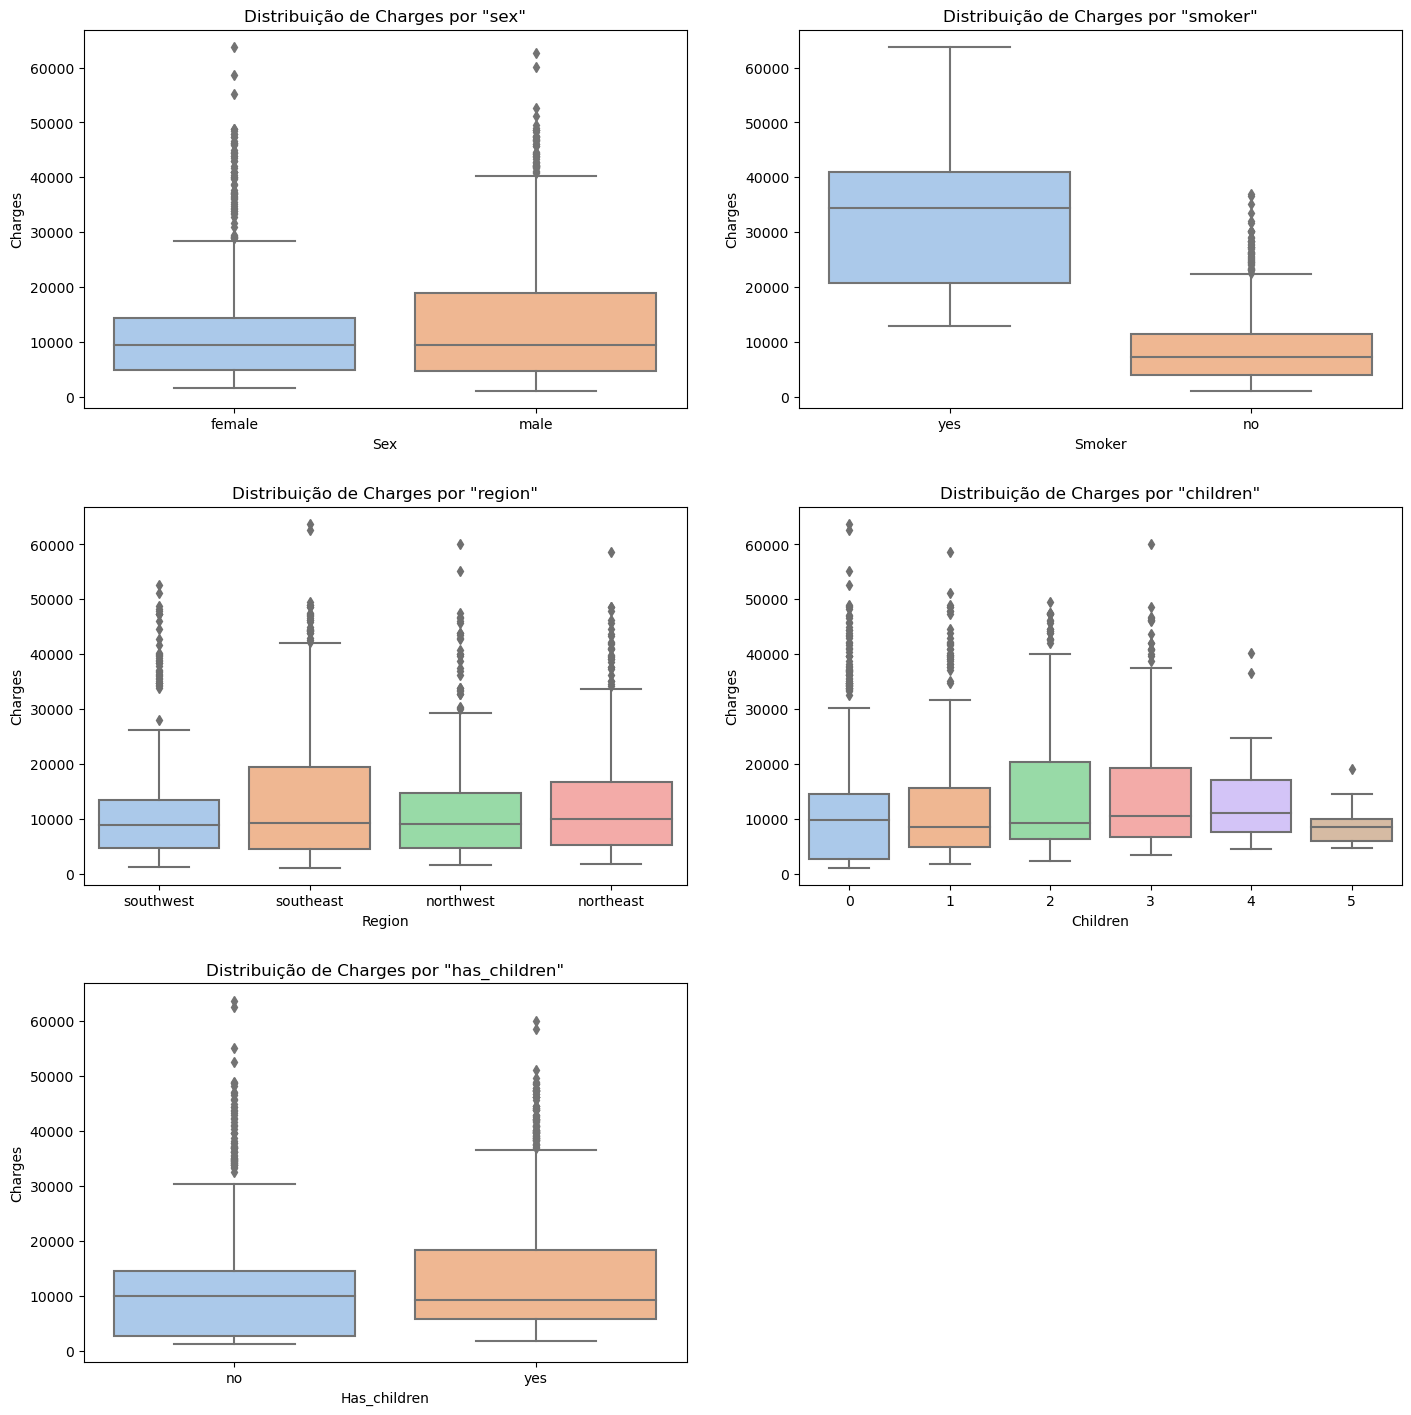

In [157]:
# Configura o tamanho da figura
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.tight_layout(pad=5.0)

# Lista de variáveis categóricas
cat_cols = ['sex', 'smoker', 'region', 'children', 'has_children']
titles = ['Distribuição de Charges por "sex"', 'Distribuição de Charges por "smoker"', 
          'Distribuição de Charges por "region"', 'Distribuição de Charges por "children"',
          'Distribuição de Charges por "has_children"']

# Cria os boxplots em subplots com a paleta pastel
for i, col in enumerate(cat_cols):
    sns.boxplot(data=df, x=col, y='charges', ax=axes[i // 2, i % 2], palette='pastel')
    axes[i // 2, i % 2].set_title(titles[i])
    axes[i // 2, i % 2].set_xlabel(col.capitalize())
    axes[i // 2, i % 2].set_ylabel('Charges')

# Remover o eixo não utilizado
fig.delaxes(axes[-1][1])
    
plt.show()

Com base nos boxplots fornecidos, podemos obter alguns insights sobre a relação entre **charges** (custos de planos de saúde) e as **variáveis categóricas** (sex, smoker, region):

**smoker (fumante):**

- Há uma **diferença clara nos custos** para pessoas **fumantes** em comparação com **não fumantes**.
- Os **fumantes tendem** a ter **custos médios muito mais altos**, com uma **mediana** de charges significativamente **superior à dos não fumantes**.
- A **variabilidade** dos custos entre **fumantes** também é **maior**, indicando que ser fumante é um **fator importante no aumento dos custos** dos planos de saúde.

**sex (gênero):**

- Há uma **pequena diferença** nos custos de planos de saúde **entre homens e mulheres**, com os **homens tendendo** a ter custos um pouco **mais altos em média**.
- Importante ressaltar que **essa diferença é bem menor em comparação** com o impacto observado em relação à variável fumante.


**region (região):**

- A **região Sudeste** (southeast) **tem uma mediana** de custos um pouco **mais alta** do que as **outras regiões**.
- A **região Sudoeste** (southwest) apresenta a **mediana** de custos **mais baixa**.
- Vale destacar que a **variabilidade** dos custos é **semelhante entre as regiões**, o que indica que a **localização pode ter um efeito moderado** sobre os custos, mas é menos relevante do que a variável fumante.

**children (número de filhos)**

- A **mediana dos custos** de planos é **relativamente consistente**, sem grandes mudanças visíveis.
- O grupo com **4 e 5 filhos** tem uma **menor quantidade de dados**, o que pode **afetar a confiabilidade da análise**. Esses grupos mostram uma **mediana mais baixa e maior dispersão** em **relação ao restante**.
- Existem **outliers em todos os grupos**, isso indica que **outros fatores** além do número de filhos **influenciam os custos mais altos** dos planos de saúde.
- O número de filhos **parece ter um impacto limitado** e **não é um fator determinante** isolado para os **custos dos planos**.


**has_children (tem filhos?)**:
- A **mediana dos custos** é bem próxima entre as pessoas quem **tem ou não tem filhos** e o custos são relativamente maiores para as pessoas que tem filhos, porém, **não parece ter grande impacto nos custos**.

**Conclusão**

A variável **fumante (smoker) é o fator categórico mais impactante nos custos**, com uma diferença clara na mediana e na distribuição geral. A variável region pode ter uma influência moderada, e o número de filhos tem um impacto menos evidente. O gênero, embora mostre algumas diferenças na dispersão, não parece ser um fator crucial na variação dos custos dos planos.



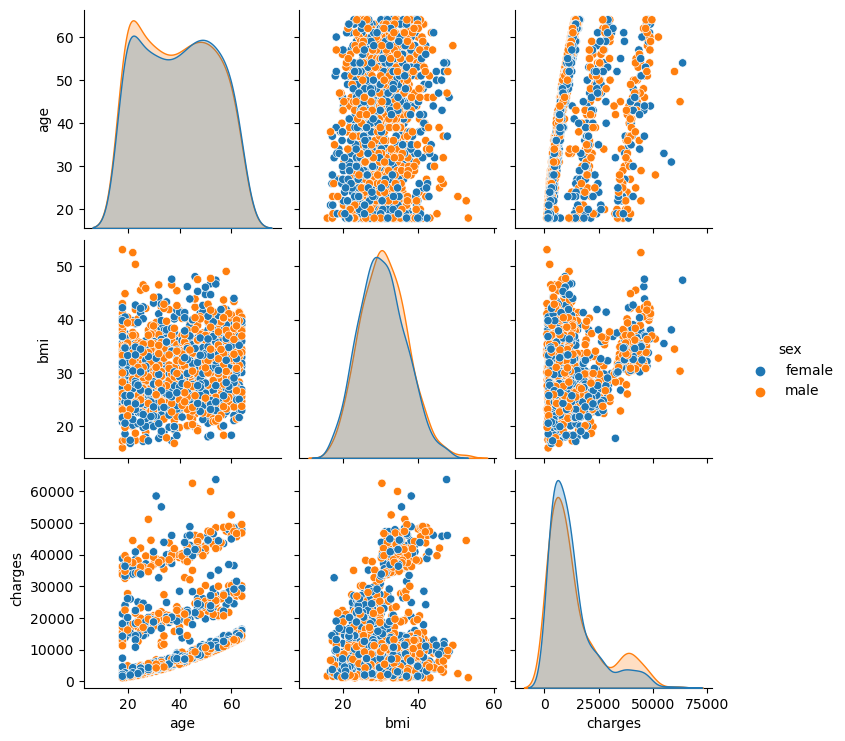

In [92]:
# Pair plot das variáveis numéricas
sns.pairplot(df, vars=['age', 'bmi', 'charges'], hue='sex')
plt.show()

### 3) Pré-processamento dos dados

Nessa etapa, o objetivo é preparar os dados para realização da análise e serão realizadas as seguintes transformações:

- Codificação das variáveis categóricas utilizando label encoding e one-hot encoding;
- Separação da variável dependente da variável independente;
- Normalização dos dados através das técnicas:
    - Min Max Scaler;
    - Standard Scaler.

In [99]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

df_coded = df.copy()
df_coded['sex'] = label_encoder.fit_transform(df_coded['sex'])
df_coded['smoker'] = label_encoder.fit_transform(df_coded['smoker'])
df_coded['has_children'] = label_encoder.fit_transform(df_coded['has_children'])

dummy_region = pd.get_dummies(df_coded['region'], prefix='dummy')
df_coded = pd.concat([df_coded, dummy_region], axis=1)
df_coded.drop("region", axis=1, inplace=True)

df_coded.head()

,age,sex,bmi,children,smoker,charges,has_children,dummy_northeast,dummy_northwest,dummy_southeast,dummy_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,0,1
1,18,1,33.770,1,0,1725.55230,1,0,0,1,0
2,28,1,33.000,3,0,4449.46200,1,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,0,1,0,0


In [185]:
(
    df_coded.corr()
    .round(2)["charges"]
    .sort_values(ascending=False)
    .to_frame()
    .reset_index()
    .rename({'index': 'variable', 'charges': 'pearson'}, axis=1)
)

,variable,pearson
0,charges,1.00
1,smoker,0.79
2,age,0.30
3,bmi,0.20
4,children,0.07
5,dummy_southeast,0.07
6,sex,0.06
7,has_children,0.06
8,dummy_northeast,0.01
9,dummy_northwest,-0.04


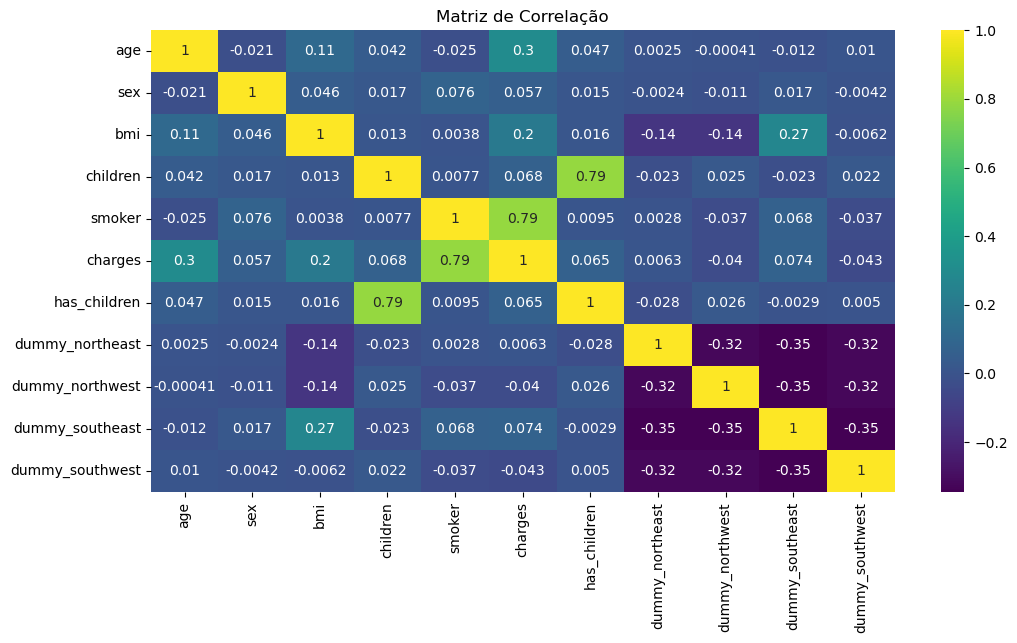

In [100]:
# Criação da matriz de correlação entre as variáveis numéricas
plt.figure(figsize=(12, 6))
sns.heatmap(df_coded.corr(), annot=True, cmap="viridis")
plt.title('Matriz de Correlação')
plt.show()


Já foi observado que as variáveis IMC e idade possuem correlação (mesmo que não muito significativa) em relação ao custo. Em relação às demais variáveis pode-se observar o seguinte resultado:

- **Ser fumante**: A **correlação é muito forte** e negativa entre não fumantes e custos (-0,79) e positiva entre fumantes e charges (0,79). Isso **indica que fumar está fortemente associado a custos médicos mais altos**.

- **Regiões**: As **correlações entre as regiões e charges são fracas**, mas a região **sudeste** apresenta a **maior correlação positiva** com charges (0,07), sugerindo um **leve aumento de custos** nessa região.

- **Sexo**: **Não há correlações significativas** entre o sexo e os custos, o que sugere que a **influência do gênero nos custos médicos é mínima** em comparação com outras variáveis.


**Conclusão**

A variável **ser fumante** (smoker) possui maior significância, apresentando **maior correlação com os custos**.

### 4) Pré-processamento dos dados


Para avaliação dos possíveis modelos a serem utilizados, serão aplicas diferentes técnicas para os datasets com e sem scaler, considerando as variáveis que possuem maior impacto de acordo com a análise realizada.

**Premissas**

1) Diferentes métodos de **feature scaling** para os datasets:
    - Sem scaler
    - Min Max Scaler
    - Standard Scaler

2) Diferentes **técnicas para regressão**:
    - SVR;
    - Decision Tree Regressor;
    - MLP Regressor;
    - Ridge;
    - Elastic Net;
    - Linear Regression;   
    - Lasso;
    - Random Forest Regressor.
    
 

3) Variáveis independentes:
    - age
    - bmi
    - smoker


In [186]:
# Função destinada a fazer a divisão dos datasets de treino e teste

def split_datasets(df, variaveis_independentes, variavel_dependente, scaler, test_size=0.2, random_state=42):
    # Seleciona as variáveis independentes e a dependente
    X = df[variaveis_independentes]
    y = df[variavel_dependente]

    if scaler:
        # Aplica o scaler nos dados
        X = scaler.fit_transform(X)

    # Separa o dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [187]:
# Printa na tela o padrao de scaler sendo analisado
def print_scaler(scaler):
    print("-----------------------------------------------------")
    print(f"- Avaliando modelos lineares usando  {scaler}-")
    print("-----------------------------------------------------")

In [248]:
# Avalia os diferentes modelos

def evaluate_models(models, df, variaveis_independentes, variavel_dependente, scaler):
    print_scaler(scaler)
    results = []
    for name, model in models:
        # Registra o tempo de início
        begin = time.time()

        X_train, X_test, y_train, y_test = split_datasets(df, variaveis_independentes, variavel_dependente, scaler)

        # Ajusta o modelo para os datasets de treino
        model.fit(X_train, y_train)

        # Realiza as predições nos datasets de teste
        y_pred = model.predict(X_test)

        # Avalia o desempenho do modelo usando MAE, MSE, RMSE e R²
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
        r2 = r2_score(y_test, y_pred)

        # Avaliando a importância das variáveis
        importancia = model.feature_importances_

        # Criando um DataFrame para visualizar
        importancia_df = pd.DataFrame({
            'Variável': X.columns,
            'Importância': importancia
        }).sort_values(by='Importância', ascending=False)
        
        # Calcula o tempo de execução
        duration = time.time() - begin

        # Print das estatísticas do modelo
        print(f'{name}: MAE = {mae:.3f} - MSE = {mse:.3f} - RMSE = {rmse:.3f} - R2 = {r2:.3f} [{duration:.3f}sec]')
    
        # Cria um dict com os resultados
        result = {
        'Scaler': scaler,
        'Modelo': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'Importancia': importancia_df,
        'Duração': duration
        }
        results.append(result)
    return results

In [287]:
# Avalia os diferentes modelos
def evaluate_models(models, df, variaveis_independentes, variavel_dependente, scaler):
    print_scaler(scaler)
    results = []
    for name, model in models:
        # Registra o tempo de início
        begin = time.time()

        X_train, X_test, y_train, y_test = split_datasets(df, variaveis_independentes, variavel_dependente, scaler)

        # Ajusta o modelo para os datasets de treino
        model.fit(X_train, y_train)

        # Realiza as predições nos datasets de teste
        y_pred = model.predict(X_test)

        # Avalia o desempenho do modelo usando MAE, MSE, RMSE e R²
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Calcula o tempo de execução
        duration = time.time() - begin

        # Calcula p-valores usando statsmodels (apenas para modelos lineares)
        try:
            X_train_const = sm.add_constant(X_train)  # Adiciona a constante para o intercepto
            modelo_stats = sm.OLS(y_train, X_train_const).fit()  # Ajusta o modelo estatístico
            p_values = modelo_stats.pvalues[1:]  # Ignora o p-valor do intercepto
        except Exception as e:
            p_values = "N/A"
            print(f"Não foi possível calcular os p-valores para o modelo {name}: {e}")

        # Print das estatísticas do modelo
        print(f'{name}: MAE = {mae:.3f} - MSE = {mse:.3f} - RMSE = {rmse:.3f} - R2 = {r2:.3f} [{duration:.3f}sec]')
    
        # Cria um dict com os resultados
        result = {
            'Scaler': scaler,
            'Modelo': name,
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae,
            'MSE': mse,
            'Duração': duration,
            'P-valor F': p_values
        }
        results.append(result)
    return results

In [284]:
df_results[0]

,Scaler,Modelo,R²,RMSE,MAE,MSE,Duração,P-valor F
0,StandardScaler(),SVR,0.717842,6618.511281,3308.205744,4.380469e+07,0.252991,x1 3.714304e-71 x2 2.792135e-24 x3 ...
1,StandardScaler(),Decision Tree Regressor,0.751360,6212.974770,3075.386390,3.860106e+07,0.023003,x1 3.714304e-71 x2 2.792135e-24 x3 ...
2,StandardScaler(),Ridge,0.777660,5875.199395,4261.978020,3.451797e+07,0.030991,x1 3.714304e-71 x2 2.792135e-24 x3 ...
3,StandardScaler(),Elastic Net,0.777502,5877.291991,4268.118427,3.454256e+07,0.038001,x1 3.714304e-71 x2 2.792135e-24 x3 ...
4,StandardScaler(),Linear Regression,0.777693,5874.763304,4260.560091,3.451284e+07,0.036984,x1 3.714304e-71 x2 2.792135e-24 x3 ...
5,StandardScaler(),Lasso,0.777693,5874.766675,4260.552862,3.451288e+07,0.022999,x1 3.714304e-71 x2 2.792135e-24 x3 ...
6,StandardScaler(),Random Forest Regressor,0.828329,5162.526723,2811.365292,2.665168e+07,0.354043,x1 3.714304e-71 x2 2.792135e-24 x3 ...


In [285]:
# Seleção das variáveis independentes
variaveis_independentes = ['age', 'bmi', 'smoker']

# Configurando modelos
regressors = [
     ('SVR                    ', SVR(kernel='linear', C=4000.0))
    ,('Decision Tree Regressor', DecisionTreeRegressor(max_depth=33))
#     ,('MLP Regressor          ', MLPRegressor(hidden_layer_sizes=(1000,), max_iter=2000))
    ,('Ridge                  ', Ridge(alpha=1.0))
    ,('Elastic Net            ', ElasticNet(alpha=0.01, l1_ratio=0.5))
    ,('Linear Regression      ', LinearRegression())
    ,('Lasso                  ', Lasso(alpha=0.1))
    ,('Random Forest Regressor', RandomForestRegressor(n_estimators=30, random_state=42))
]

In [286]:
results_standard = evaluate_models(regressors, df_coded, variaveis_independentes, variavel_dependente='charges', scaler=StandardScaler())
results_minmax = evaluate_models(regressors, df_coded, variaveis_independentes, variavel_dependente='charges', scaler=MinMaxScaler())
results = evaluate_models(regressors, df_coded, variaveis_independentes, variavel_dependente='charges', scaler=None)

-----------------------------------------------------
- Avaliando modelos lineares usando  StandardScaler()-
-----------------------------------------------------
<class 'pandas.core.series.Series'>
-----------------------------------------------------
- Avaliando modelos lineares usando  MinMaxScaler()-
-----------------------------------------------------
<class 'pandas.core.series.Series'>
-----------------------------------------------------
- Avaliando modelos lineares usando  None-
-----------------------------------------------------
<class 'pandas.core.series.Series'>


In [259]:
df_results = [
    pd.DataFrame(results_standard),
    pd.DataFrame(results_minmax),
    pd.DataFrame(results)]

-----------------------------------------------------
- Avaliando modelos lineares usando  StandardScaler()-
-----------------------------------------------------


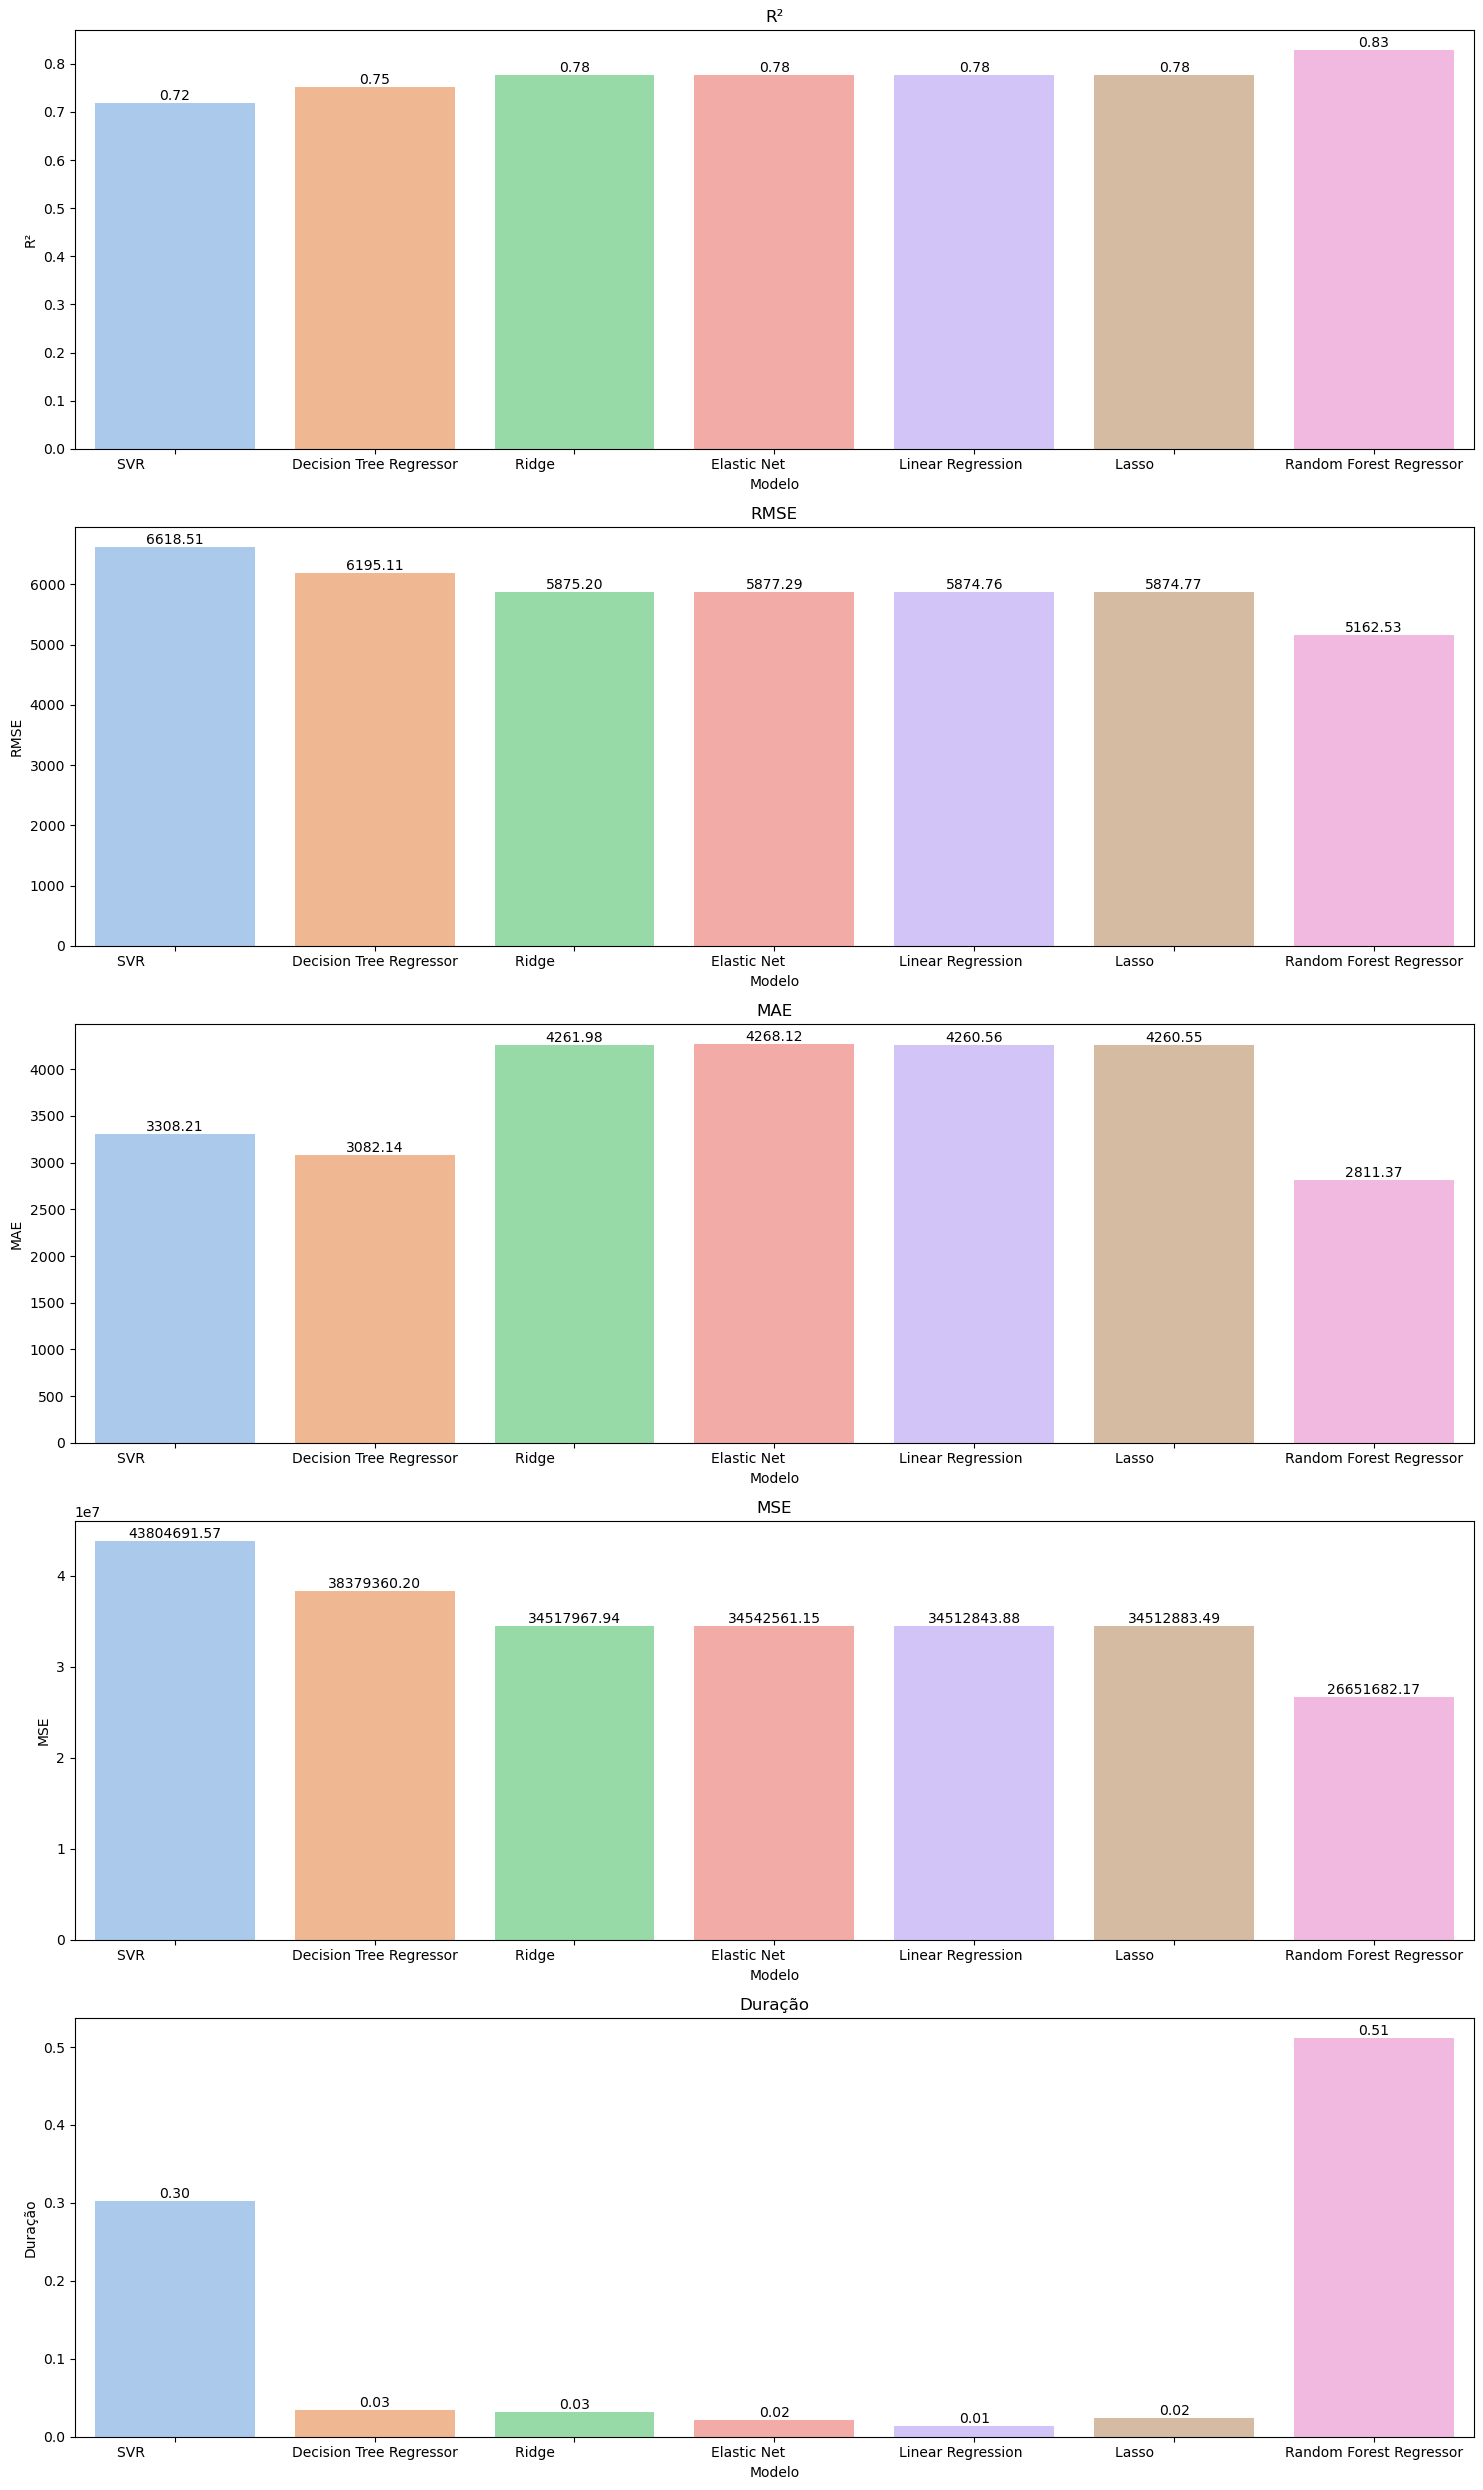

-----------------------------------------------------
- Avaliando modelos lineares usando  MinMaxScaler()-
-----------------------------------------------------


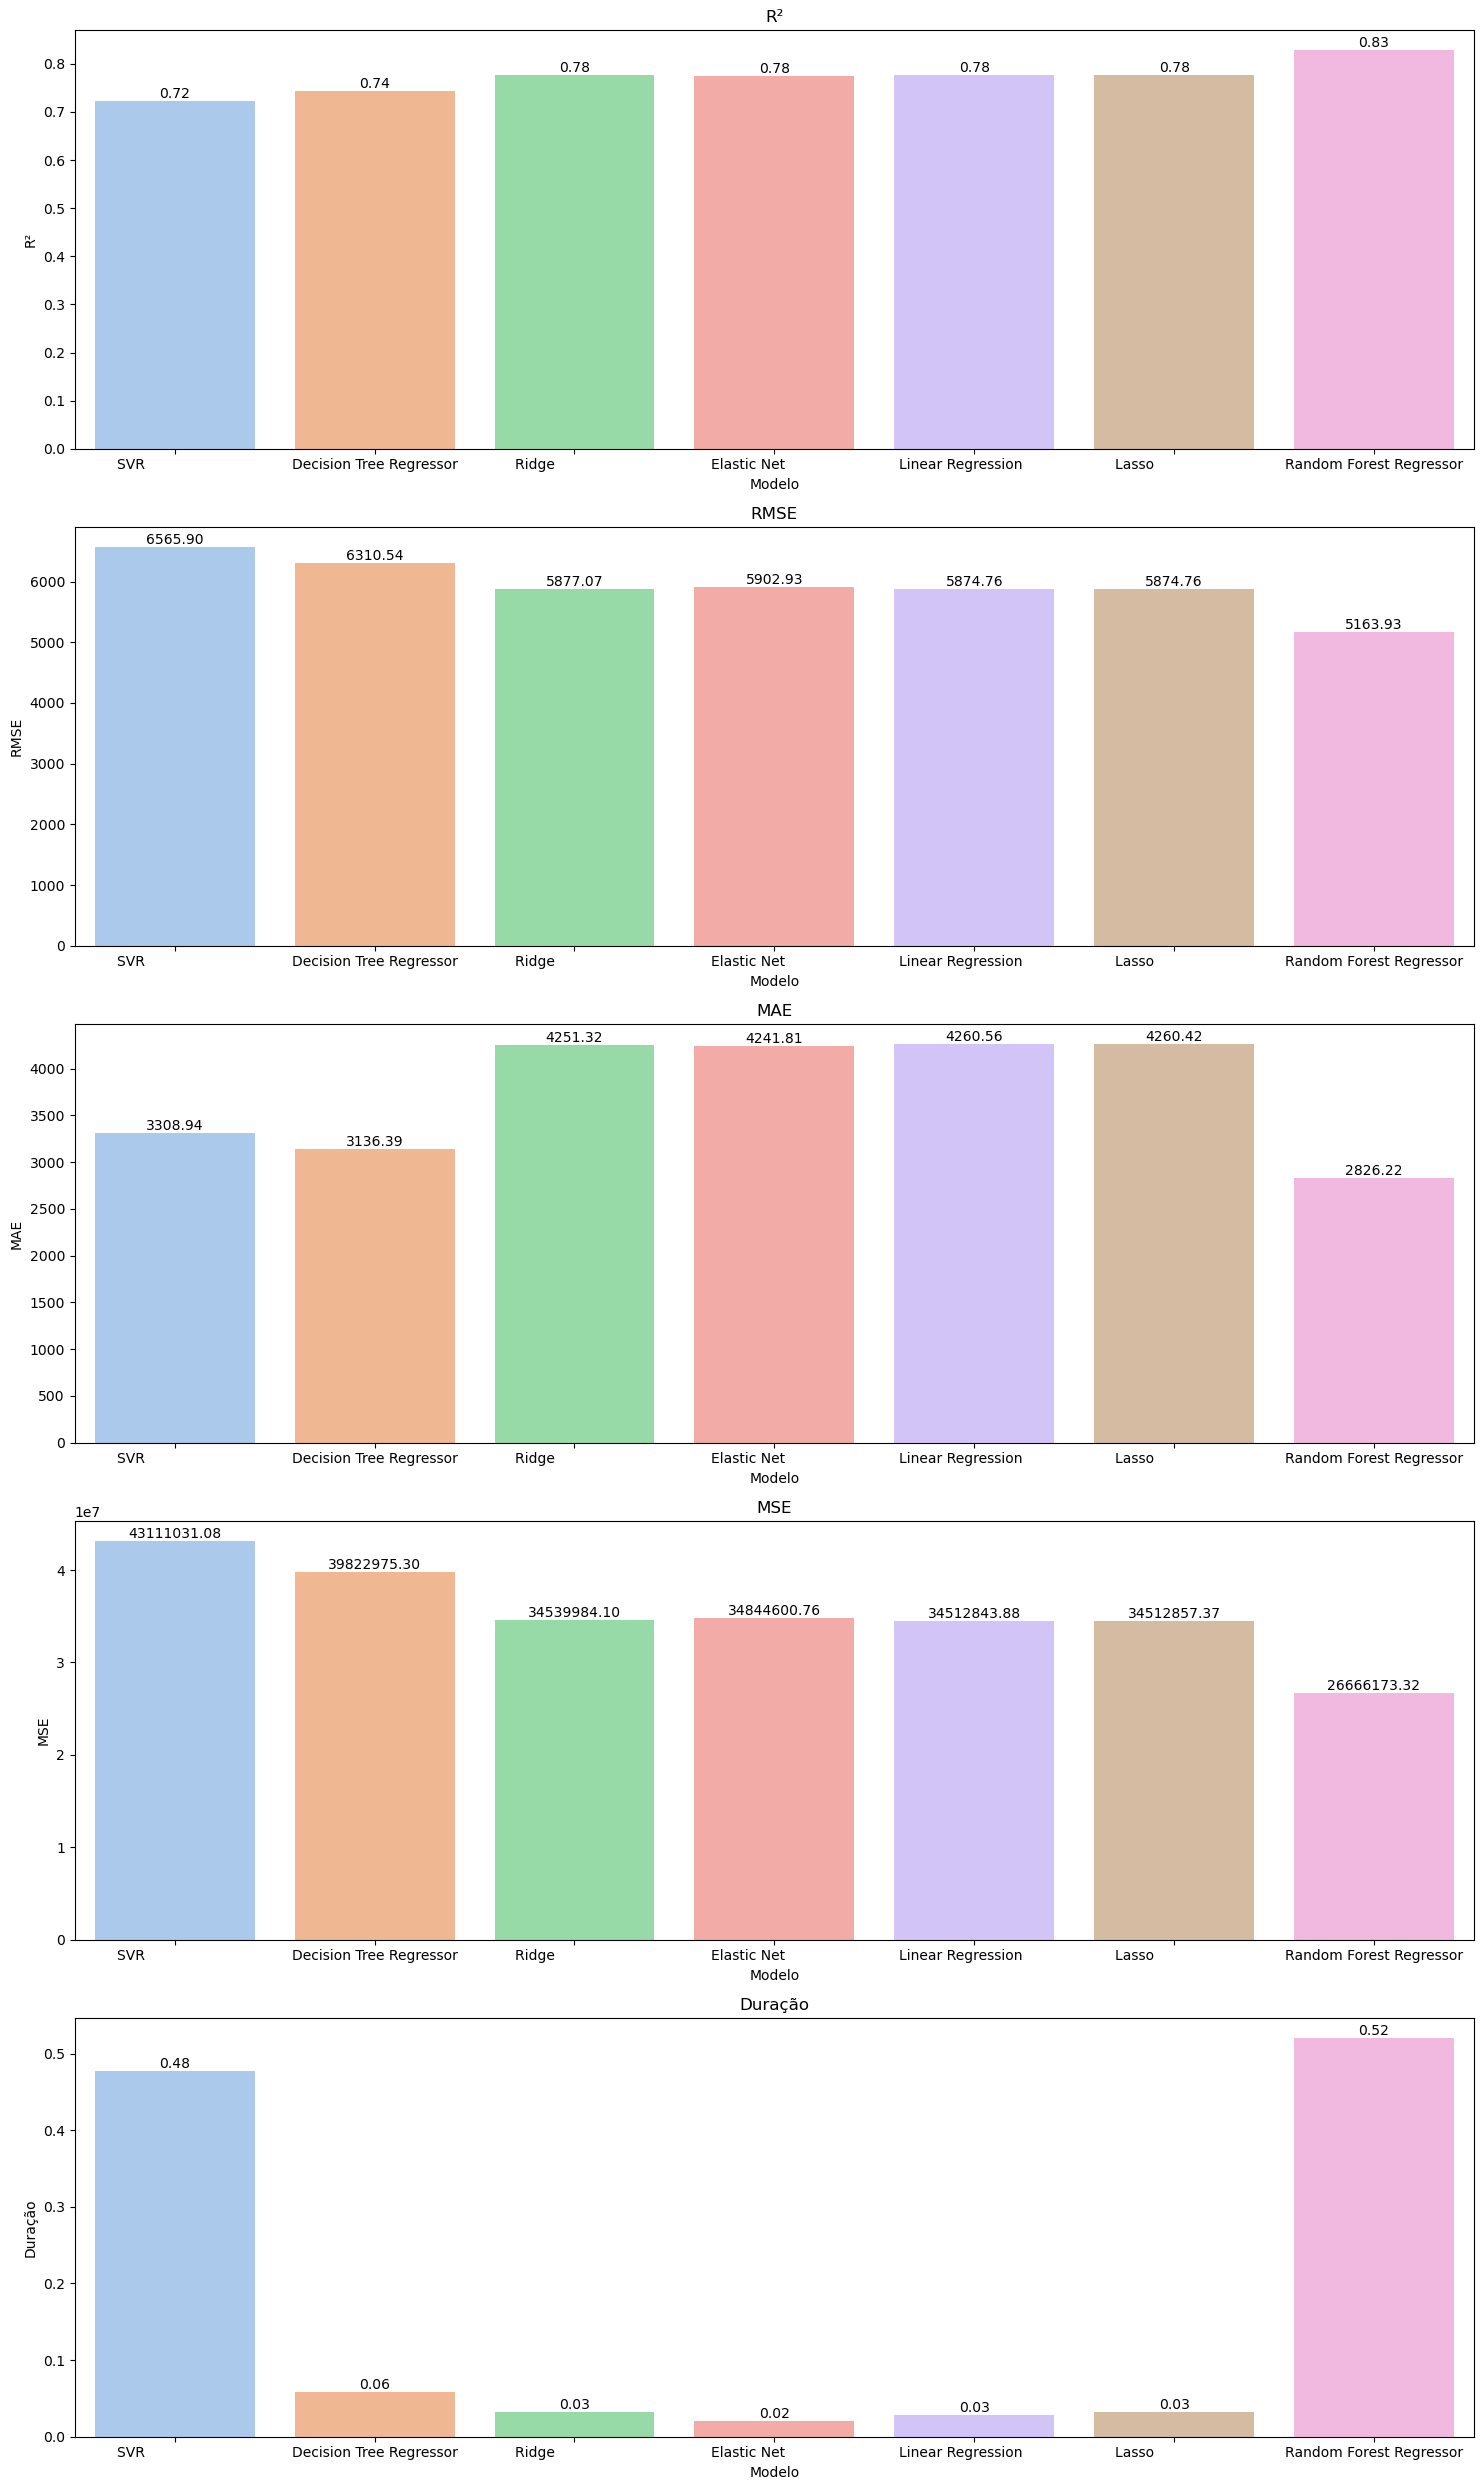

-----------------------------------------------------
- Avaliando modelos lineares usando  SemScaler-
-----------------------------------------------------


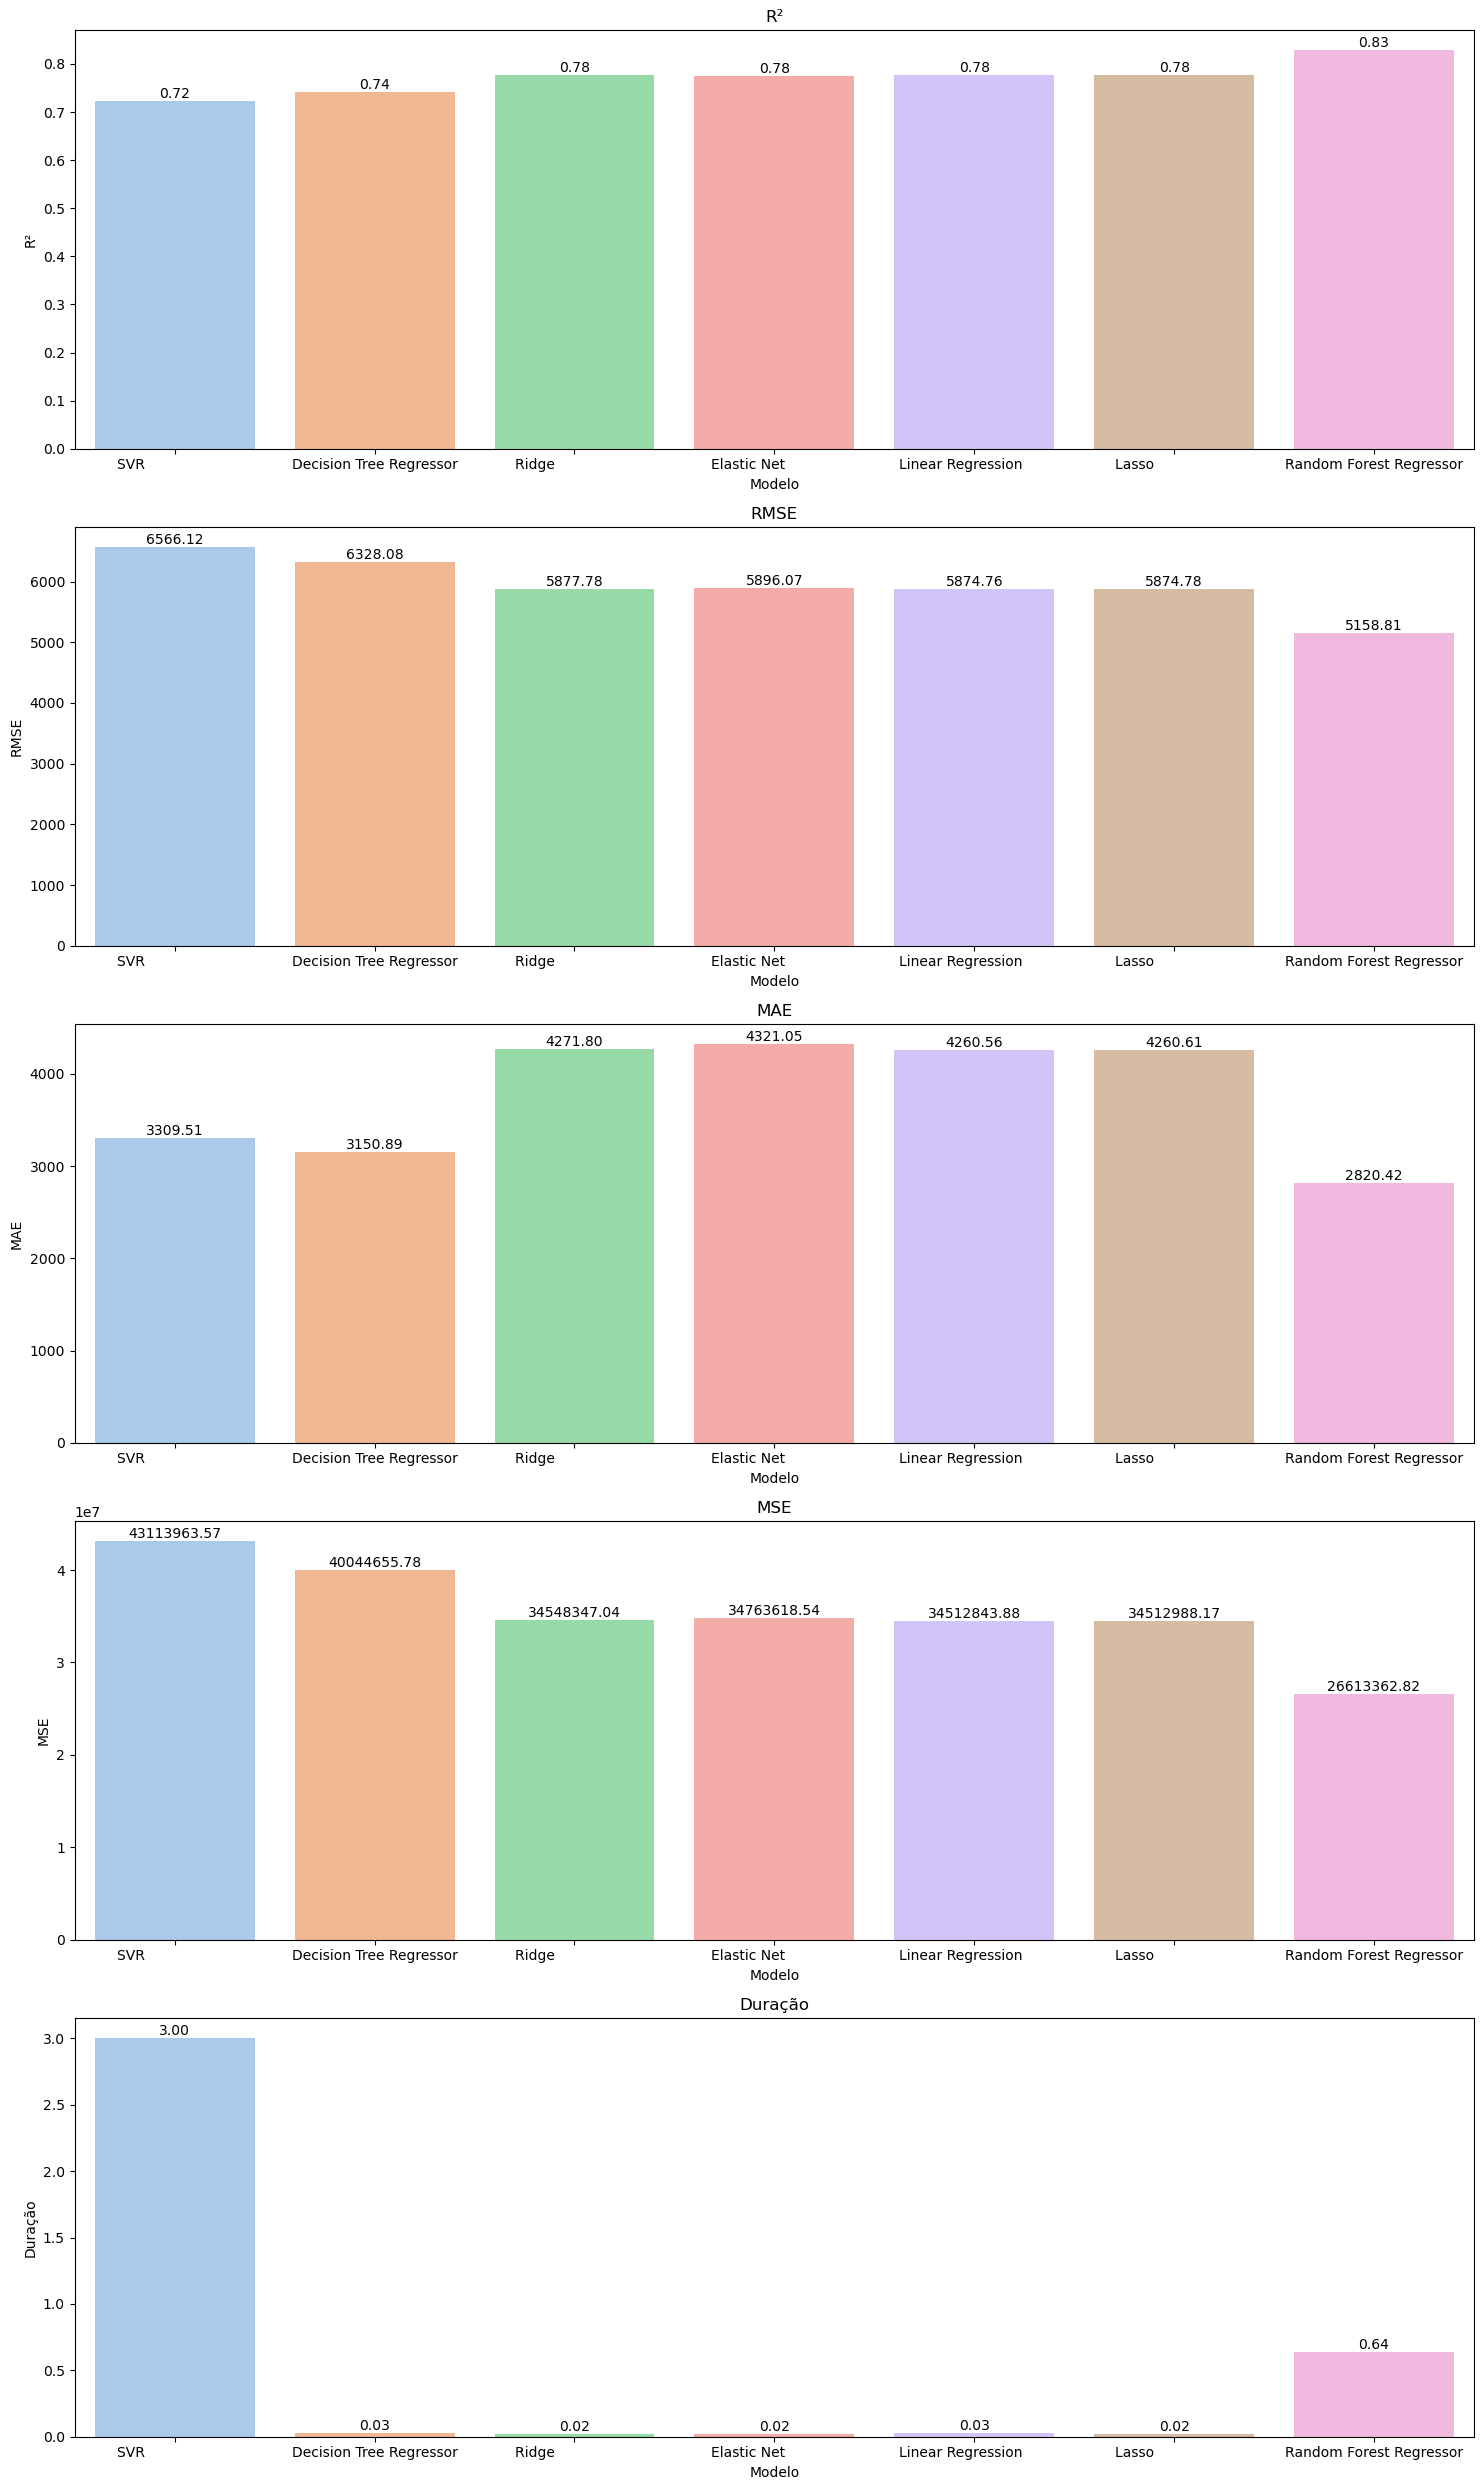

In [240]:
def generate_graphs(df_results):

    # Listando as métricas para iterar sobre elas
    metrics = ['R²', 'RMSE', 'MAE', 'MSE', 'Duração']
    
    # Configurando a paleta de cores
    palette = sns.color_palette('pastel')
    
    # Configurando os subplots
    fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 25), sharey=False)

    # Criando um gráfico de barras para cada métrica
    for i, metric in enumerate(metrics):
        sns.barplot(data=df_results, x='Modelo', y=metric, ax=axes[i], palette=palette)
        axes[i].set_title(metric)
        axes[i].set_xlabel('Modelo')
        for bar in axes[i].containers[0]:
            axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                          f'{bar.get_height():.2f}', ha='center', va='bottom')

    if i == 0:
        axes[i].set_ylabel('Valor')

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()

for r in df_results:
    r["Scaler"].fillna("SemScaler", inplace=True)
    print_scaler(r["Scaler"].unique()[0])
    generate_graphs(r)

In [320]:
p_values = (
    df_results[2] # Dataset com os resultados da abordagem sem Scaler
    .loc[df_results[2]['Modelo'] == 'Random Forest Regressor']['P-valor F'] # Filtrando o modelo e selecionando atributo
    .to_numpy()[0] # Converte para array e retorna a primeira posição
    .to_numpy() # Converte a primeira posição para array somente os valores 
)

for var, p in zip(variaveis_independentes, p_values):
    print(f'O p-valor da variável {var} é: {p}. \n')

O p-valor da variável age é: 3.714303547683245e-71. 

O p-valor da variável bmi é: 2.7921352067083835e-24. 

O p-valor da variável smoker é: 2.7093354572758147e-287. 



De acordo com as métricas avaliadas, os modelos **MLP Regressor** e o **Random Forest** foram os que apresentaram os **melhores resultados**, porém, o **Random Forest Regressor se destaca em todas as abordagens** (StandardScaler, MinMaxScaler e sem scaler), apresentando o menor MAE, MSE e RMSE, além do maior R² em comparação com os outros modelos. Também apresenta uma **performance consistente**, sendo o **melhor modelo entre os testados**.


Abaixo temos as métricas do Random Forest para as 3 abordagens:

1. Random Forest com StandardScaler:

- MAE = 2811.365
- MSE = 26651682.167
- RMSE = 5162.527
- R² = 0.828

2. Random Forest com MinMaxScaler


- MAE = 2826.220
- MSE = 26666173.323
- RMSE = 5163.930
- R² = 0.828

3. Random Forest sem Scaler

- MAE = 2820.420
- MSE = 26613362.823
- RMSE = 5158.814
- R² = 0.829


**Conclusão**

A **Random Forest sem Scaler é a melhor opção**, pois tem um R² de 0,829, ou seja, **explica 82,9% dos dados**. Além de ter o **menor MSE e RMSE**, que indica que a **variabilidade entre os valores previstos e reais possuem o menor erro**. 

Esses indicadores sugerem que o modelo está proporcionando **previsões mais precisas**.



